In [18]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dask import delayed
import seaborn as sns
import scipy.stats as sstats
import glob
from dask import delayed
from time import time
import bottleneck as bn
sns.set(style='whitegrid',font_scale=1.3,context='talk')

In [19]:
# read vertical grid
path = './output_2013asiri_06b/'
zgrid = pd.read_csv(path+'zgrid.out', skipinitialspace=True, sep=' ', header=None)[1][1:51].astype(float).values

In [66]:
def find_mld_1d(dataflat,zgrid):
    sortind = dataflat.argsort()
    datasorted=dataflat[sortind]
    zgrid = zgrid[sortind]
    return np.interp(dataflat[-7]+0.03,datasorted,zgrid)

def ts_to_days(timestep,sec_per_timestep=288):
    return timestep*sec_per_timestep/86400

In [77]:
@delayed
def find_mld(ds):
    mld=[]
    for i in range(0,len(ds.x),10): # subsampling
        for j in range(0,len(ds.y),10):
            mld.append( find_mld_1d(ds.rho[:,j,i].values.flatten()-1000,zgrid))
    #mldmode,_ = sstats.mode(mld,)
    return bn.nanmedian(mld)

In [78]:
# workflow to lazily compute MLD
end = np.int( glob.glob('./output_2013asiri_06b/full_*.cdf')[-1][-9:-4] )
print(end)
template = './output_2013asiri_06b/full_{:05d}.cdf'
filenames = (template.format(k) for k in range(0,end,100)) # 300ts = 1d
datasets = (xr.open_dataset(fname) for fname in filenames)
totals = [find_mld(ds) for ds in datasets]
mld = [item.compute() for item in totals]

20750


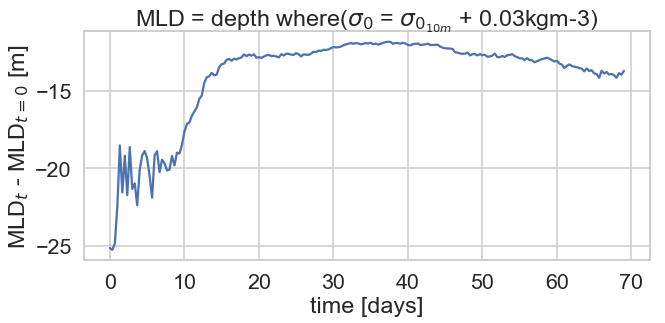

In [79]:
plt.figure(figsize=(10,5))
plt.plot(ts_to_days(np.arange(0,end,100)),(mld))
plt.xlabel('time [days]')
plt.ylabel(r'MLD$_t$ - MLD$_{t=0}$ [m]')
plt.title(r'MLD = depth where($\sigma_0$ = $\sigma_{0_{10m}}$ + 0.03kgm-3)')
plt.tight_layout()
plt.savefig('mld_timeseries_06_%d.pdf' %end,bb_inches='tight')
plt.show()